In [64]:
import typing
import io
import os

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import make_grid

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

import math
from copy import deepcopy

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


class TransformerEncoder(nn.Module):
    def __init__(self, image_size: int = 36, hidden_size: int = 768,
                 num_head: int = 12, attention_size: int = 768,
                 num_mlp_layers: int = 2, num_encoder_layers: int = 12,
                 dropout: float = .2, num_classes: int = 10, div_term: int = 3):
        super(TransformerEncoder, self).__init__()
        self.model_name = "ViT AKA image transformer"

        self.image_size = image_size
        self.hidden_size = hidden_size
        self.num_head = num_head
        self.attention_size = attention_size
        self.dropout = dropout
        self.num_mlp_layers = num_mlp_layers
        self.num_encoder_layers = num_encoder_layers
        self.num_classes = num_classes

        # list to store attention weights for visualizing purposes
        self.attn_weights = []

        # check to see if we can break image to N tiles
        self.N = int(math.pow(div_term, 2))  # N aka number of tiles
        assert image_size % self.N == 0
        self.num_input_features = int(math.pow(image_size / div_term, 2)) * 3

        # Define embedding linear projection
        self.embedding = nn.Linear(self.num_input_features, hidden_size)
        # Define learnable positional embeddings of size (N+1), hidden_size
        self.pos_embedding = nn.Parameter(torch.zeros((1, self.N + 1, hidden_size)))
        # define class learnable class token
        self.cls_token = nn.Parameter(torch.zeros((1, 1, hidden_size)))

        # define encoder layers
        layer = TransformerEncoderLayer(input_size=self.num_input_features, hidden_size=hidden_size,
                                        num_head=num_head, attention_size=attention_size,
                                        num_mlp_layers=num_mlp_layers, N=self.N, dropout=dropout,
                                        attn_weights=self.attn_weights).to(device)

        encoder_layers = []
        for _ in range(num_encoder_layers):
            encoder_layers.append(deepcopy(layer))

        self.encoder_layers = nn.Sequential(*encoder_layers)

        # define final MLP head for classification
        self.mlp = MLP(hidden_size=hidden_size, num_layers=num_mlp_layers, out_size=num_classes, dropout=dropout).to(
            device)

    def forward(self, x):
        """

        :param x: image tensor of size (B, C, H, W)
        :return: prediction for each class of size (B, num_classes) & attention weights of all layers
        """

        B = x.size(0)
        x = x.view(B, self.N, -1)
        cls_token = self.cls_token.expand(B, 1, self.hidden_size)

        # apply embedding to image
        x = self.embedding(x)
        # cat class token
        x = torch.cat([cls_token, x], dim=1)
        # apply positional embedding
        x = x + self.pos_embedding

        attn_weights = []
        for layer in self.encoder_layers:
            x = layer(x, attn_weights)

        x = self.mlp(x[0])
        # we only going to need class token output
        x = x[:, 1, :]  # x is of size (B, 1, num_classes)

        return x.view(B, -1), attn_weights


class TransformerEncoderLayer(nn.Module):
    def __init__(self, input_size: int = 363, hidden_size: int = 768,
                 num_head: int = 12, attention_size: int = 768,
                 num_mlp_layers: int = 2, N: int = 9, dropout: float = .2,
                 attn_weights: list = []):
        super(TransformerEncoderLayer, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_head = num_head
        self.attention_size = attention_size
        self.dropout = dropout
        self.num_mlp_layers = num_mlp_layers
        self.N = N
        self.attn_weights = attn_weights  # to store attention weight across layers

        self.multi_head_attention = Multi_Head_Attention(hidden_size=hidden_size, num_head=num_head,
                                                         attention_size=hidden_size, dropout=dropout).to(device)
        self.mlp = MLP(hidden_size=hidden_size, num_layers=num_mlp_layers, out_size=hidden_size, dropout=dropout).to(
            device)

        self.norm1 = nn.LayerNorm(hidden_size, eps=1e-6)
        self.norm2 = nn.LayerNorm(hidden_size, eps=1e-6)

    def forward(self, x, attn_weights=None):
        """

        :param x: tuple of encoder layer input of size (B, N, hidden_size) & list of attention weights
        :return:
        """
        if len(attn_weights) != 0:
            x, attn_weights = x

        # attention part
        x1 = x
        x1 = self.norm1(x1)
        x1, weights = self.multi_head_attention(x1)
        x = x + x1

        # mlp part
        x1 = x
        x1 = self.norm2(x1)
        x1 = self.mlp(x1)
        x = x + x1

        attn_weights.append(weights.cpu())
        return x, attn_weights


class Multi_Head_Attention(nn.Module):
    def __init__(self, hidden_size: int, num_head: int, attention_size: int, dropout: float):
        super(Multi_Head_Attention, self).__init__()
        # check if number if hidden size can be divided number of heads
        assert attention_size % num_head == 0

        self.hidden_size = hidden_size
        self.attention_size = attention_size
        self.num_head = num_head

        # define Q K V linear
        self.Q = nn.Linear(hidden_size, hidden_size)
        self.K = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, hidden_size)

        self.linear_projection = nn.Linear(hidden_size, hidden_size)

        self.attention_dropout = nn.Dropout(p=dropout)
        self.projection_dropout = nn.Dropout(p=dropout)

        self.init_weights()

    def forward(self, x: Tensor):
        """

        :param x: image batch of size (B, N, hidden_size)
        :return: output of multi-head attention and attention weights
        """
        B, N = x.size()[:2]

        # covert inputs to desired shape
        q = self.Q(x)
        k = self.K(x)
        v = self.V(x)

        # reshape q, k and v into multi head shape (B, N, num_heads, rest) then permute dim 1&2

        q = q.view(B, N, self.num_head, -1).permute(0, 2, 1, 3)
        k = k.view(B, N, self.num_head, -1).permute(0, 2, 1, 3)
        v = v.view(B, N, self.num_head, -1).permute(0, 2, 1, 3)

        weights = torch.matmul(q, k.transpose(2, 3)) / math.sqrt(self.attention_size)
        weights = F.softmax(weights, dim=-1)
        weights = self.attention_dropout(weights)

        # calculate new outputs
        new_values = torch.matmul(weights, v)

        # reshape to original size
        new_values = new_values.permute(0, 2, 1, 3).contiguous().view(B, N, -1)

        output = self.projection_dropout(self.linear_projection(new_values))

        return output, weights

    def init_weights(self):
        nn.init.xavier_uniform_(self.Q.weight)
        nn.init.xavier_uniform_(self.K.weight)
        nn.init.xavier_uniform_(self.V.weight)
        nn.init.xavier_uniform_(self.linear_projection.weight)

        nn.init.normal_(self.Q.bias, std=1e-6)
        nn.init.normal_(self.K.bias, std=1e-6)
        nn.init.normal_(self.V.bias, std=1e-6)
        nn.init.normal_(self.linear_projection.bias, std=1e-6)


class MLP(nn.Module):
    def __init__(self, hidden_size: int, out_size: int, num_layers: int, dropout: float):
        super(MLP, self).__init__()

        fc_layers = []
        self.num_layers = num_layers

        for _ in range(num_layers - 1):
            fc_layers.append(nn.Linear(hidden_size, hidden_size).to(device))
            fc_layers.append(nn.GELU())
            fc_layers.append(nn.Dropout(p=dropout))

        self.fc_layers = nn.Sequential(*fc_layers)

        self.fc_last = nn.Linear(hidden_size, out_size)
        self.drop_last = nn.Dropout(p=dropout)

        self.init_weights()

    def init_weights(self):
        for module in self.fc_layers.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.normal_(module.bias, std=1e-6)

        nn.init.xavier_uniform_(self.fc_last.weight)
        nn.init.normal_(self.fc_last.bias, std=1e-6)

    def forward(self, x: Tensor):
        """

        :param x: output of multi-head attention of size (B, N, hidden_size)
        :return:
        """

        x = self.fc_layers(x)
        x = self.fc_last(x)
        x = self.drop_last(x)
        return x


In [90]:
# define model and load state_dcit
model = TransformerEncoder()

checkpoint = torch.load('/content/drive/MyDrive/checkpoint.pth', map_location='cpu')
state_dict = checkpoint['state_dict']

model.load_state_dict(state_dict)
model.eval()

# define data
T = [
    transforms.Resize(36),
    transforms.ToTensor(),
]

data = datasets.CIFAR10(root='./cifar-10', train=True, download=True, transform=transforms.Compose(T))

x = data[5000][0]
im = transforms.ToPILImage()(x)

x = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))(x)


Files already downloaded and verified


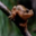

In [91]:
display(im)

In [92]:
logits, att_mat = model(x.unsqueeze(0))

att_mat = torch.stack(att_mat).squeeze(1)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = mask.reshape(36, 36)#.astype("uint8")

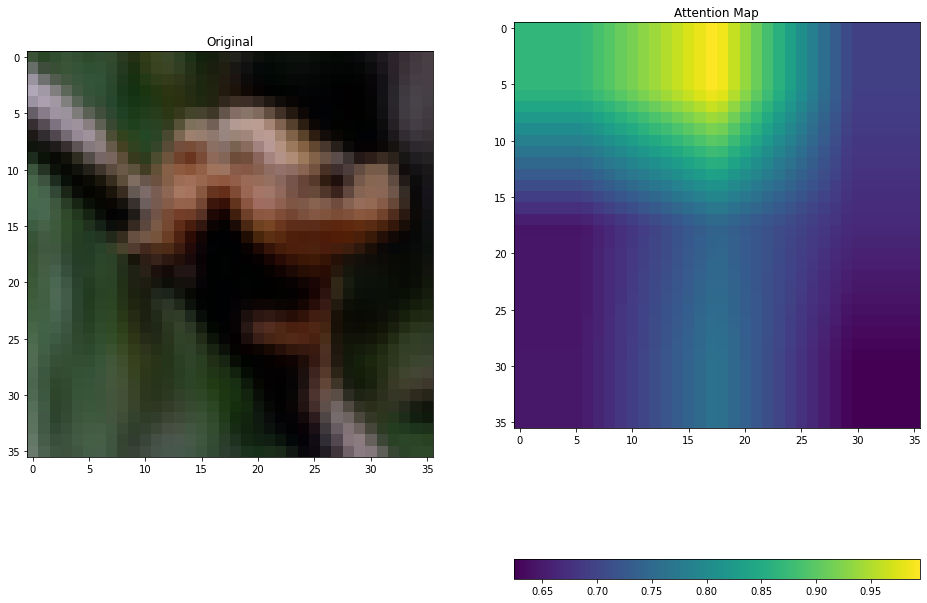

In [93]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
k1 = ax1.imshow(im)
k = ax2.imshow(result)
plt.colorbar(k, orientation='horizontal')